In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_scheduler.scheduler.utils import SkyAreaGenerator
%matplotlib inline

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def calculate_qso_numbers(baseline, nside, maps, outdir, ourdir_db, DDF=False):
    """
    Calculate QSO numbers for different filters.

    Parameters:
    baseline (str): Path to the baseline database file.
    nside (int): HEALPix resolution parameter.
    maps (array): Array of HEALPix IDs to use.
    outdir (str): Output directory for results.
    ourdir_db (str): Directory for results database.

    Returns:
    dict: Metric bundles for each filter.
    """
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')  # Extract the simulation name from the baseline file
    bundles = {}
    
    dustmap = maf.DustMap(nside=nside)  # Create a DustMap object for the given resolution
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)  # Define slicer for HEALPix regions based on selected maps
    
    # Loop through the filters (u, g, r, i, z, y) to calculate QSO numbers for each band
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        metric = maf.QSONumberCountsMetric(f, zmax=6.7)  # Create QSO number count metric for the filter
        
        # SQL constraint: exclude 'DD%' targets if DDF is False, otherwise use all targets
        if DDF==False:
            sql = f'target_name not like "DD%" and filter = "{f}"'
        else:
            sql = f'filter = "{f}"'
        
        # Create MetricBundle for each filter with the QSO count metric
        bundle = maf.MetricBundle(metric, slicer, sql, run_name=run_name, maps_list=[dustmap], info_label=f'{f} band')
        bundles[f] = bundle

    # Create a ResultsDb to store results and run the MetricBundleGroup
    results_db = maf.db.ResultsDb(out_dir=ourdir_db)
    bundle_group = maf.MetricBundleGroup(bundles, baseline_file, out_dir=outdir, results_db=results_db)
    bundle_group.run_all()
    return bundles

def calculate_5sigma_depth(baseline, qso_bundles, outdir, ourdir_db, DDF=False):
    """
    Compute 5-sigma depth using QSO slicer.

    Parameters:
    baseline (str): Path to the baseline database file.
    qso_bundles (dict): QSO metric bundles.
    outdir (str): Output directory for results.
    ourdir_db (str): Directory for results database.

    Returns:
    dict: 5-sigma depth metric bundles for each filter.
    """
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    bundles = {}
    
    # Loop through filters to compute 5-sigma depth for each
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        qso_bundle = qso_bundles[f]
        slicer = qso_bundle.slicer
        
        # Use only valid HEALPix IDs where QSO counts are non-zero
        valid_hpid = np.where(qso_bundle.metric_values.filled(0) > 0)[0]
        slicer = maf.HealpixSubsetSlicer(nside=slicer.nside, hpid=valid_hpid)
        
        depth_metric = maf.Coaddm5Metric()  # Use 5-sigma depth metric
        
        # Define SQL constraint for 5-sigma depth
        if DDF==False:
            depth_sql = f'target_name not like "DD%" and filter = "{f}"'
        else:
            depth_sql = f'filter = "{f}"'   
        
        # Create MetricBundle for 5-sigma depth and add it to the bundles dictionary
        depth_bundle = maf.MetricBundle(depth_metric, slicer, depth_sql, run_name=run_name, info_label=f'{f} band 5-sigma depth')
        bundles[f] = depth_bundle

    # Create a ResultsDb and run the MetricBundleGroup
    results_db = maf.db.ResultsDb(out_dir=ourdir_db)
    bundle_group = maf.MetricBundleGroup(bundles, baseline_file, out_dir=outdir, results_db=results_db)
    bundle_group.run_all()
    return bundles

def calculate_sky_area(bundles, nside):
    """
    Calculate the total sky area for each filter.

    Parameters:
    bundles (dict): Metric bundles for each filter.
    nside (int): HEALPix resolution parameter.

    Returns:
    dict: Total sky area for each filter.
    """
    area_per_band = {}
    pixel_area = (4 * np.pi / (12 * nside**2)) * (180 / np.pi)**2  # Convert from steradians to square degrees
    
    # Loop through filters and calculate the area for each band
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        bundle = bundles[f]
        valid_pixels = np.sum(bundle.metric_values.mask == False)  # Count valid pixels with data
        total_area = valid_pixels * pixel_area  # Calculate total area
        area_per_band[f] = total_area
        print(f'Total area for {f} band: {total_area:.2f} square degrees')
    
    return area_per_band

def calculate_total_qsos(bundles):
    """
    Calculate the total number of QSOs for each filter.

    Parameters:
    bundles (dict): Metric bundles for each filter.

    Returns:
    dict: Total number of QSOs for each filter.
    """
    total_qsos_per_band = {}
    summary = maf.SumMetric(col='metric', metric_name='Total QSO')  # Sum the QSO counts
    
    # Loop through filters to calculate total QSOs for each
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        bundles[f].set_summary_metrics([summary])  # Set the summary metric for the filter
        bundles[f].compute_summary_stats()  # Compute summary statistics
        total_qsos = bundles[f].summary_values['Total QSO']  # Get total QSOs for this filter
        total_qsos_per_band[f] = total_qsos
        print(f'Total QSO count in {f} band: {total_qsos}')
    
    return total_qsos_per_band

def plot_qso_number_distribution(bundles):
    """
    Plot the QSO number distribution for each filter.

    Parameters:
    bundles (dict): Metric bundles for each filter.

    Returns:
    int: Always returns 0.
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    # Loop through filters and plot QSO number distribution for each
    for i, f in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
        qso_bundle = bundles[f]
        qso_values = qso_bundle.metric_values.compressed()  # Get the QSO values
        
        # Create histogram of the QSO distribution
        hist, bin_edges = np.histogram(qso_values, bins='auto')
        summary = maf.SumMetric(col='metric', metric_name='Total QSO')
        qso_bundle.set_summary_metrics([summary])
        qso_bundle.compute_summary_stats()
        total_qsos = qso_bundle.summary_values['Total QSO']
    
        # Plot the histogram
        axes[i].hist(qso_values, bins='auto', edgecolor='black')
        print(np.median(qso_values))  # Print the median QSO value
        axes[i].set_xlabel('NQSO/square degree')
        axes[i].set_ylabel('Area (square degrees)')
        axes[i].set_title(f'QSO Number Distribution in {f} band\nTotal QSO count: {total_qsos:.0f}')
        
    fig.delaxes(axes[-1])  # Remove the last unused subplot
    plt.tight_layout()
    plt.show()  # Display the plot
    return 0

def plot_mollweide_projection(bundles, filter_band, title, xlabel, color_min=None, color_max=None, figformat='png'):
    """
    Plot a Mollweide projection for the specified filter band.

    Parameters:
    bundles (dict): Metric bundles for each filter.
    filter_band (str): Filter band to plot ('u', 'g', 'r', 'i', 'z', 'y').
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    color_min (float, optional): Minimum value for the color bar.
    color_max (float, optional): Maximum value for the color bar.
    out_dir (str, optional): Directory to save the output plot.
    opsim (str, optional): Name of the opsim run.
    figformat (str, optional): Format of the output plot, default is 'png'.

    Returns:
    int: Always returns 0.
    """
    bundle = bundles[filter_band]

    plot_dict = {
        'figsize': (8, 7),
        'labelsize': 'x-large',
        'fontsize': 'x-large',
        'xlabel': xlabel,
        'extend': 'max'
    }
    if color_min is not None:
        plot_dict['color_min'] = color_min
    if color_max is not None:
        plot_dict['color_max'] = color_max

    ph = maf.PlotHandler(savefig=False, fig_format=figformat, thumbnail=False, dpi=270)
    ph.set_metric_bundles([bundle])
    ph.plot(plot_func=maf.plots.HealpixSkyMap(), plot_dicts=plot_dict)
    
    plt.title(title, fontsize='xx-large', fontweight='normal')
    
    #plt.savefig(os.path.join(out_dir, f'{opsim}_{filter_band}_mollweide.{figformat}'), 
    #                facecolor='w', edgecolor='w', bbox_inches='tight', dpi=270, format=figformat)
    
    plt.show()
    

In [4]:
# Define baseline database and HEALPix resolution
baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
nside = 64

# Generate the sky area maps using the SkyAreaGenerator class
survey_areas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = survey_areas.return_maps()

# Set output directories for results
outdir = './Output'
ourdir_db = './Output/'

def cal_area(maps, nside, baseline, outDir):
    """
    Calculate the area based on the number of visits metric.
    Parameters:
    - maps: Selected HEALPix IDs to include.
    - nside: The HEALPix resolution.
    - baseline: Path to the baseline database.
    - outDir: Output directory to store results.

    Returns:
    - bundle: The MetricBundle object used in the calculation.
    - total_area: The total area covered by the valid pixels.
    """
    # Define the metric to count the number of visits
    count_metric = maf.CountMetric(col='observationStartMJD', metric_name='NVisits')
    
    # Define slicer to select specific HEALPix regions
    slicer = maf.HealpixSubsetSlicer(nside=nside, hpid=maps)
    
    # Set constraint as None
    constraint = None
    
    # Extract the simulation name from the baseline file
    opsim = os.path.basename(baseline).replace('.db', '')
    
    # Create a MetricBundle for counting visits
    bundle = maf.MetricBundle(count_metric, slicer, constraint, run_name=opsim)
    
    # Run the MetricBundleGroup
    g = maf.MetricBundleGroup({'nvisits': bundle}, baseline, out_dir=outDir)
    g.run_all()
    
    # Calculate the area of each pixel and the total area for valid pixels
    npix = 12 * nside**2
    area_per_pixel = 41253 / npix  # Convert from steradians to square degrees
    valid_pixels = np.sum(bundle.metric_values > 0)
    total_area = valid_pixels * area_per_pixel
    return bundle, total_area

# Select HEALPix regions based on map labels
maps = np.where(
    (map_labels == 'LMC_SMC') |
    (map_labels == 'bulge') |
    (map_labels == 'dusty_plane') |
    (map_labels == '') |
    (map_labels == 'lowdust') |
    (map_labels == 'nes') |
    (map_labels == 'scp') |
    (map_labels == 'virgo')
)[0]

# Call the area calculation function for selected maps
bundle, total_area = cal_area(maps, nside, baseline, outdir)

# Define specific regions (WFD, GP, SCP, NES) based on metric values and map labels
map_WFD = np.where(
    (((map_labels == 'dusty_plane') |
      (map_labels == '') |
      (map_labels == 'bulge') |
      (map_labels == 'LMC_SMC')
     ) &
    (bundle.metric_values > 650)
    ) | 
    (map_labels == 'virgo') |
    (map_labels == 'lowdust')
)[0]

map_GP = np.where(
    (   (map_labels == '') |
        (map_labels == 'bulge') |
        (map_labels == 'dusty_plane') 
    )&
    (bundle.metric_values <= 650)
)[0]

map_SCP = np.where(
    (map_labels == 'scp') |
    ((map_labels == 'LMC_SMC') &
    (bundle.metric_values <= 650))
)[0]

map_NES = np.where(map_labels == 'nes')[0]

# Calculate QSO numbers for different regions and print results
print('Total QSO number (+DDF):')
NQSO_bundles = calculate_qso_numbers(baseline, nside, maps, outdir, ourdir_db, DDF=True)
Nqso_per_band = calculate_total_qsos(NQSO_bundles)  # Calculate total QSOs for each band
area_per_band = calculate_sky_area(NQSO_bundles, nside=nside)  # Calculate area for each filter

# Calculate QSO numbers for the same regions without DDF
print('Total QSO number (-DDF):')
NQSO_bundles_noDDF = calculate_qso_numbers(baseline, nside, maps, outdir, ourdir_db, DDF=False)
Nqso_per_band = calculate_total_qsos(NQSO_bundles_noDDF)
area_per_band = calculate_sky_area(NQSO_bundles_noDDF, nside=nside)

# Calculate QSO numbers for WFD region
print('QSO number (WFD):')
NQSO_bundles_WFD = calculate_qso_numbers(baseline, nside, map_WFD, outdir, ourdir_db, DDF=False)
Nqso_per_band = calculate_total_qsos(NQSO_bundles_WFD)
area_per_band = calculate_sky_area(NQSO_bundles_WFD, nside=nside)

# Calculate QSO numbers for GP region
print('QSO number (GP):')
NQSO_bundles_GP = calculate_qso_numbers(baseline, nside, map_GP, outdir, ourdir_db, DDF=False)
Nqso_per_band = calculate_total_qsos(NQSO_bundles_GP)
area_per_band = calculate_sky_area(NQSO_bundles_GP, nside=nside)

# Calculate QSO numbers for SCP region
print('QSO number (SCP):')
NQSO_bundles_SCP = calculate_qso_numbers(baseline, nside, map_SCP, outdir, ourdir_db, DDF=False)
Nqso_per_band = calculate_total_qsos(NQSO_bundles_SCP)
area_per_band = calculate_sky_area(NQSO_bundles_SCP, nside=nside)

# Calculate QSO numbers for NES region
print('QSO number (NES):')
NQSO_bundles_NES = calculate_qso_numbers(baseline, nside, map_NES, outdir, ourdir_db)
Nqso_per_band = calculate_total_qsos(NQSO_bundles_NES)
area_per_band = calculate_sky_area(NQSO_bundles_NES, nside=nside)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Total QSO number (+DDF):
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Total QSO count in u band: 6497858.657473752
Total QSO count in g band: 10534558.923388641
Total QSO count in r band: 11982786.965695284
Total QSO count in i band: 12305842.340346713
Total QSO count in z band: 11896190.989005037
Total QSO count in y band: 9439473.659878768
Total area for u band: 23789.78 square degrees
Total area for g band: 26541.82 square degrees
Total area for r band: 26574.55 square degrees
Total area for i band: 26570.36 square degrees
Total area for z band: 26552.73 square degrees
Total area for y band: 23705.85 square degrees
Total QSO number (-DDF):
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Total QSO count in u band: 6492703.8357675485
Total QSO count in g band: 10530682.90978405
Total QSO count in r band: 11979078.770475801
Total QSO count in i band: 12299

In [6]:
print('Total QSO number (+DDF):')
NQSO_bundles = calculate_qso_numbers(baseline, nside, maps, outdir, ourdir_db, DDF=True)
Nqso_per_band = calculate_total_qsos(NQSO_bundles)
area_per_band = calculate_sky_area(NQSO_bundles,nside=nside)

Total QSO number (+DDF):
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Total QSO count in u band: 6497858.657473752
Total QSO count in g band: 10534558.923388641
Total QSO count in r band: 11982786.965695284
Total QSO count in i band: 12305842.340346713
Total QSO count in z band: 11896190.989005037
Total QSO count in y band: 9439473.659878768
Total area for u band: 23789.78 square degrees
Total area for g band: 26541.82 square degrees
Total area for r band: 26574.55 square degrees
Total area for i band: 26570.36 square degrees
Total area for z band: 26552.73 square degrees
Total area for y band: 23705.85 square degrees


253.5874539596839
350.45754869100074
398.64309266356605
409.9676393260877
399.2768522498915
358.74240939371725


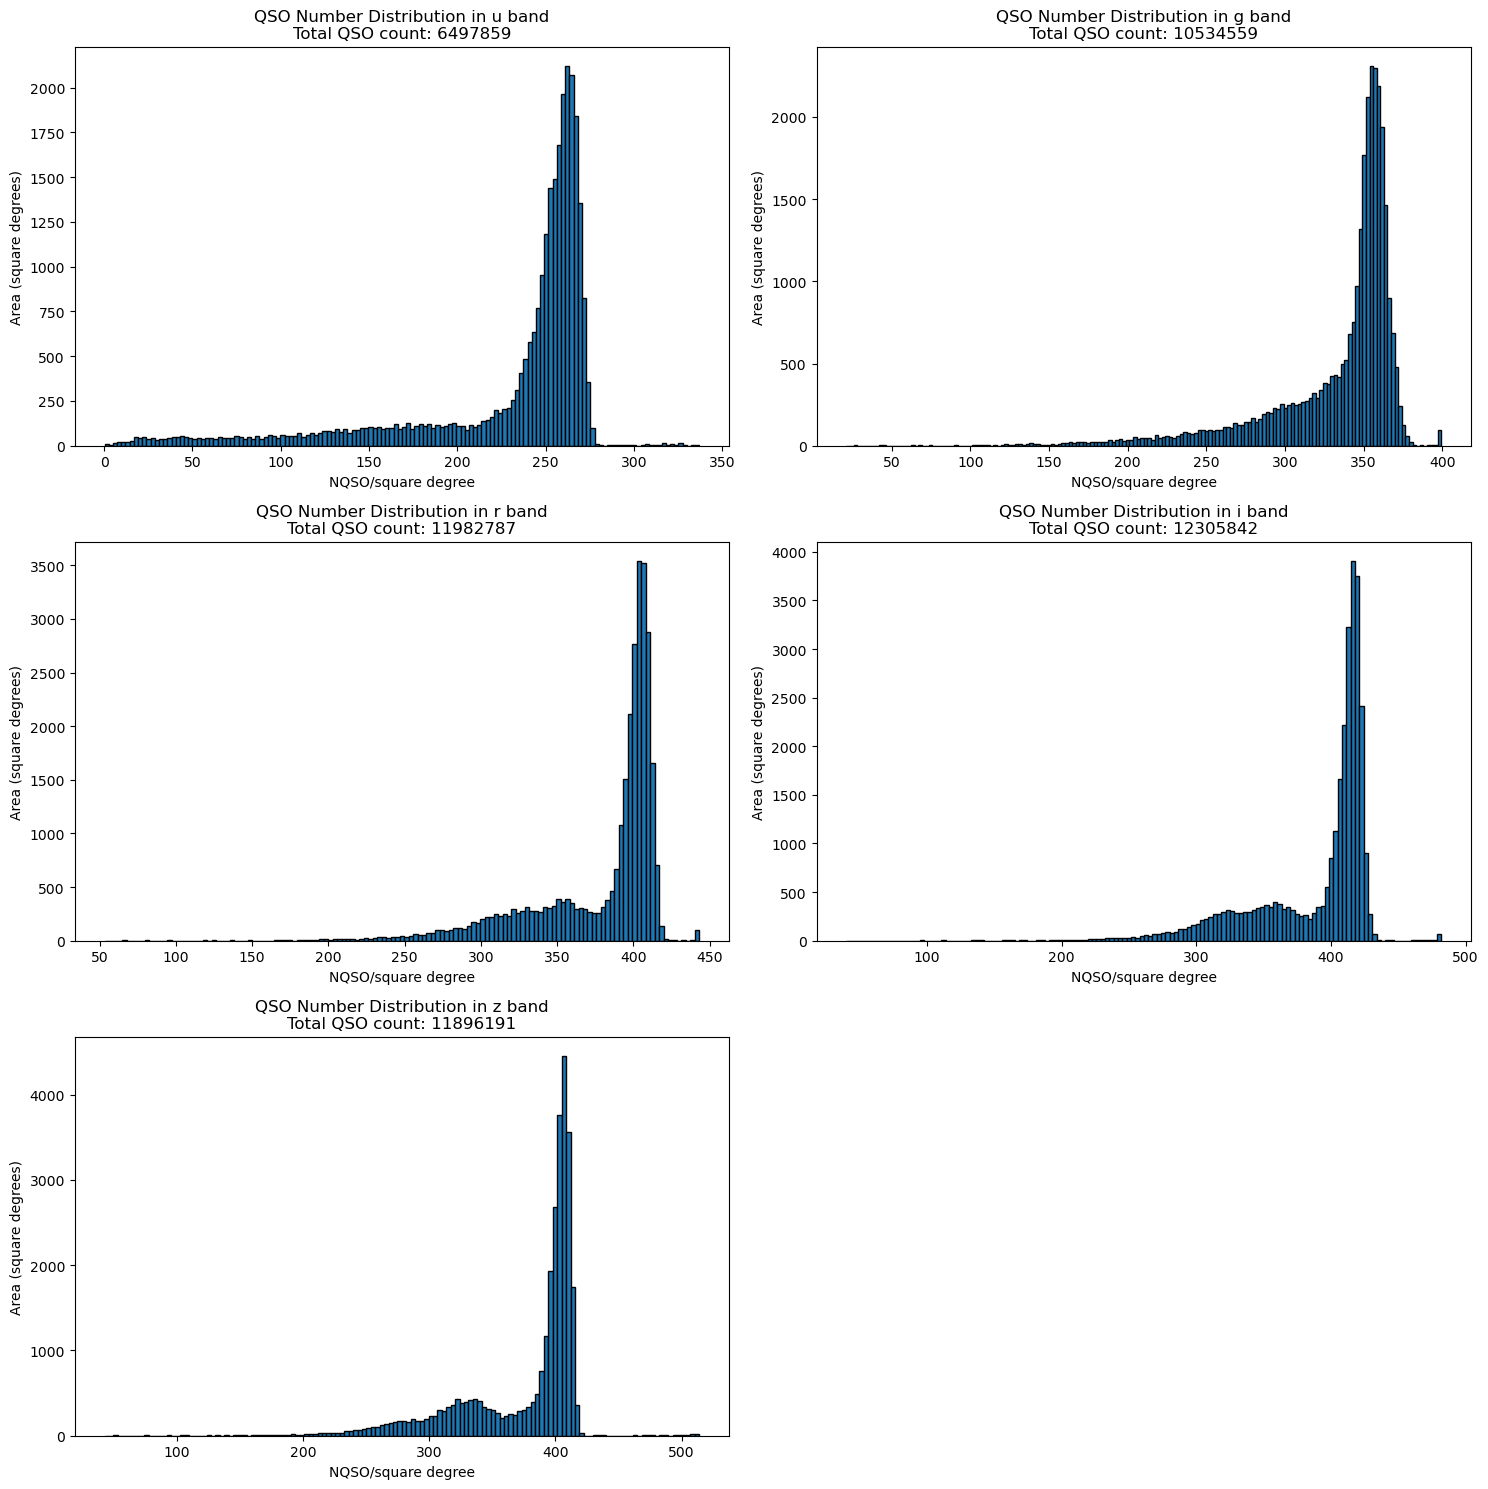

0

In [7]:
plot_qso_number_distribution(NQSO_bundles)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
u 25.56485208519627 26.00901908970996 18937.00030517578
g 26.768761707059443 27.658412348134767 1893

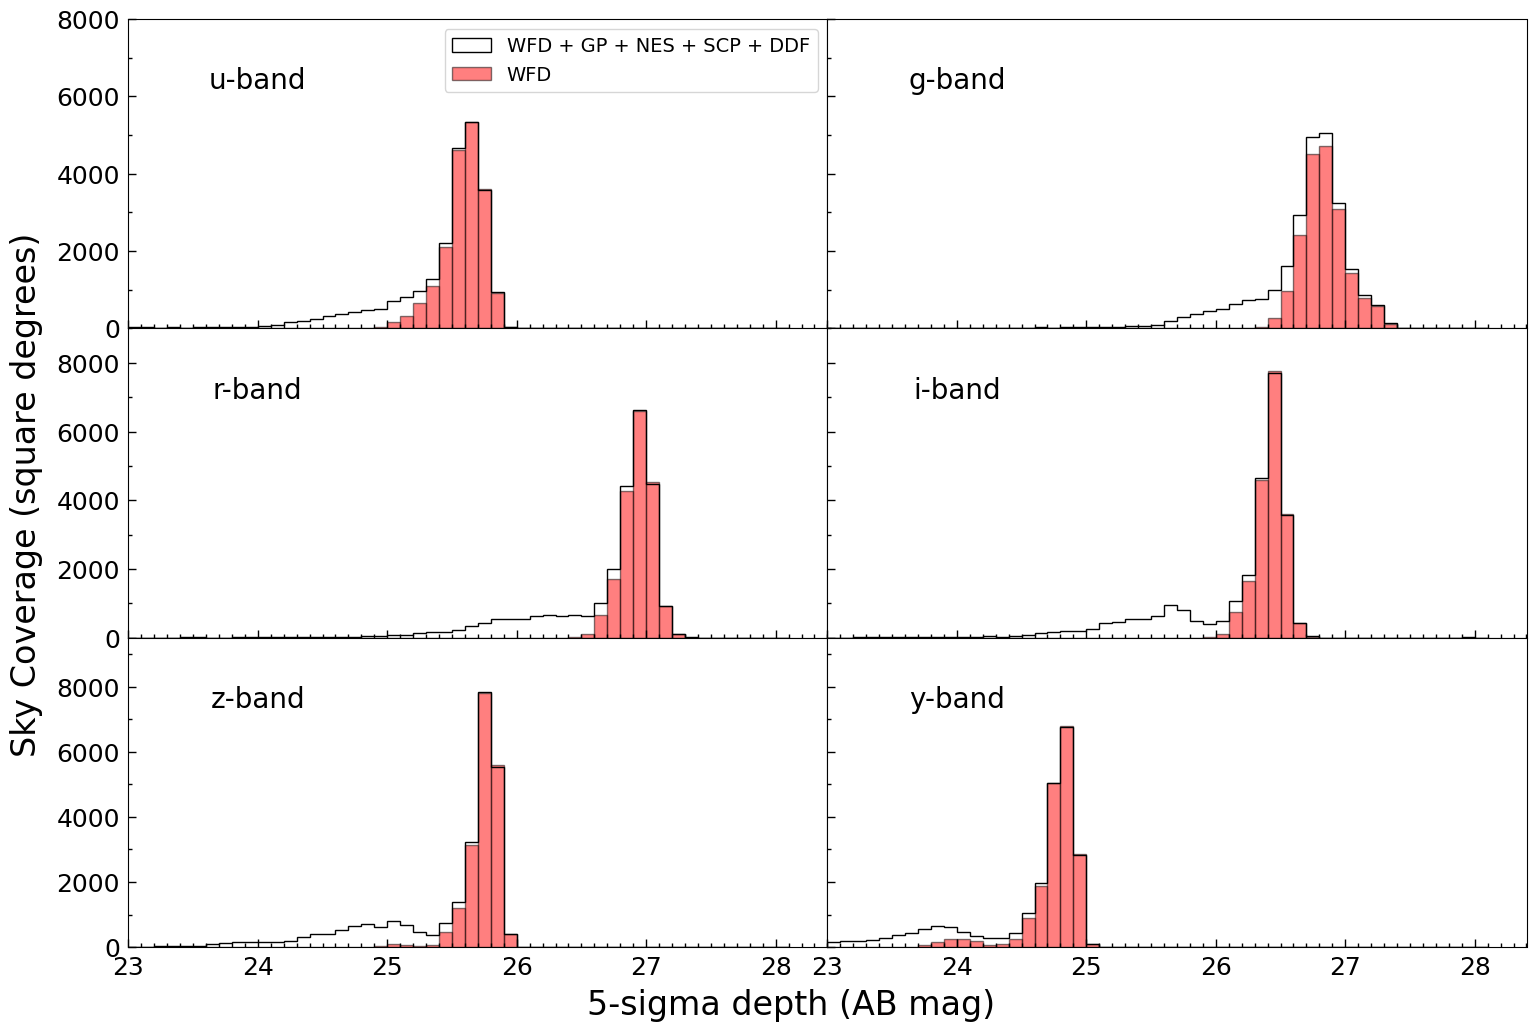

In [8]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def plot_5sigma_histograms(bundleGroups_all_maps, bundleGroups_WFD, nside, output_path='./Figure2.png'):
    """
    Function to plot histograms of 5-sigma depth for different filters, comparing the full sky to the WFD (Wide-Fast-Deep) region.

    Parameters:
    bundleGroups_all_maps (dict): Metric bundles for all maps.
    bundleGroups_WFD (dict): Metric bundles for the WFD region.
    nside (int): HEALPix resolution parameter.
    output_path (str): Path to save the output figure.
    """
    npix = 12 * nside**2  # Number of pixels in a full sky at the given nside resolution
    area_per_pixel = 41253 / npix  # Area per pixel in square degrees (41253 is the total sky area in square degrees)
    
    filters = ['u', 'g', 'r', 'i', 'z', 'y']  # List of filters to plot
    fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex='col', sharey='row', 
                            gridspec_kw={'wspace': 0, 'hspace': 0})  # Create subplots for each filter
    axs = axs.flatten()  # Flatten the 2D array of axes to make it easier to loop through
    bins = np.arange(23, 28.1, 0.1)  # Define histogram bins for 5-sigma depths
    
    # Set y-axis limits for each subplot
    axs[0].set_ylim(0,8000)
    axs[1].set_ylim(0,8000)
    axs[2].set_ylim(0,9000)
    axs[3].set_ylim(0,9000)
    axs[4].set_ylim(0,9500)
    axs[5].set_ylim(0,9500)
    
    for i, filter_band in enumerate(filters):
        # Get data for all maps (full sky) for the current filter
        bundle_all_maps = bundleGroups_all_maps[filter_band]
        data_all_maps = bundle_all_maps.metric_values.compressed()  # Compresses the masked values (ignoring NaNs)
        
        # Get data for the WFD region for the current filter
        bundle_WFD = bundleGroups_WFD[filter_band]
        data_WFD = bundle_WFD.metric_values.compressed()  # Compresses the masked values
        
        # Plot histogram for all maps (full sky)
        axs[i].hist(data_all_maps, bins=bins, edgecolor='black', label='WFD + GP + NES + SCP + DDF', histtype='step',\
                   weights=[area_per_pixel] * len(data_all_maps))
        
        # Plot histogram for the WFD region
        axs[i].hist(data_WFD, bins=bins, color='red', alpha=0.5, edgecolor='black', label='WFD',\
                   weights=[area_per_pixel] * len(data_WFD))
        
        # Print the median of all maps, max value of WFD, and area covered by WFD
        print(filter_band, np.median(data_all_maps), np.max(data_WFD), len(data_WFD)*area_per_pixel)
        
        # Set the x-axis limits for 5-sigma depths
        axs[i].set_xlim(23,28.4)

        # Define tick locators and format for the plots
        ymajorLocator = MultipleLocator(2000)
        yminorLocator = MultipleLocator(1000)
        xmajorLocator = MultipleLocator(1)
        xminorLocator = MultipleLocator(0.1)
        axs[i].yaxis.set_major_locator(ymajorLocator)
        axs[i].yaxis.set_minor_locator(yminorLocator)
        axs[i].xaxis.set_major_locator(xmajorLocator)
        axs[i].xaxis.set_minor_locator(xminorLocator)
        
        # Customize tick parameters
        axs[i].tick_params(axis='both', which='major', tickdir='in', labelsize=18, width=1, pad=6, length=6, bottom=True, top=False, left=True, right=False)
        axs[i].tick_params(axis='both', which='minor', tickdir='in', width=1, length=3, bottom=True, top=False, left=True, right=False)
        
        # Get y-axis max value to adjust text position
        y_max = axs[i].get_ylim()[1]
        
        # Add label for the filter band
        axs[i].text(24, 0.8 * y_max, filter_band+'-band', fontsize=20, verticalalignment='center', horizontalalignment='center')

        # Display legend only on the first subplot
        if i == 0:
            axs[i].legend(loc='upper right', fontsize=14)
        
        # Remove y-axis ticks for rightmost columns and x-axis ticks for the top row
        if i % 2 != 0:
            axs[i].yaxis.set_tick_params(labelleft=False)
        if i < 4:
            axs[i].xaxis.set_tick_params(labelbottom=False)
        
        # Only show ticks facing inward
        axs[i].tick_params(axis='both', direction='in')
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)
    
    # Add axis labels
    fig.text(0.5, -0.01, '5-sigma depth (AB mag)', ha='center', va='center', fontsize=24)
    fig.text(-0.01, 0.5, 'Sky Coverage (square degrees)', ha='center', va='center', rotation='vertical', fontsize=24)
    
    # Tight layout for the figure
    plt.tight_layout()

    # Save the figure as a PNG file
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Calculate the 5-sigma depth for EM5 simulation and WFD region
EM5_depth = calculate_5sigma_depth(baseline, NQSO_bundles, outdir, ourdir_db, DDF=True)
EM5_depth_WFD = calculate_5sigma_depth(baseline, NQSO_bundles_WFD, outdir, ourdir_db, DDF=False)

# Plot the 5-sigma histograms
plot_5sigma_histograms(EM5_depth, EM5_depth_WFD, nside)

In [14]:
def calculate_qso_numbers_DDF(baseline, nside, maps, outdir, ourdir_db):
    """
    Calculate QSO numbers for different filters.

    Parameters:
    baseline (str): Path to the baseline database file.
    nside (int): HEALPix resolution parameter.
    maps (array): Array of HEALPix IDs to use.
    outdir (str): Output directory for results.
    ourdir_db (str): Directory for results database.

    Returns:
    dict: Metric bundles for each filter.
    """
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')  # Extract the simulation name from the baseline file
    bundles = {}
    
    dustmap = maf.DustMap(nside=nside)  # Create a DustMap object for the given resolution
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)  # Define slicer for HEALPix regions based on selected maps
    
    # Loop through the filters (u, g, r, i, z, y) to calculate QSO numbers for each band
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        metric = maf.QSONumberCountsMetric(f, zmax=6.7)  # Create QSO number count metric for the filter
        
        sql = f'target_name like "DD%" and filter = "{f}"'
        
        # Create MetricBundle for each filter with the QSO count metric
        bundle = maf.MetricBundle(metric, slicer, sql, run_name=run_name, maps_list=[dustmap], info_label=f'{f} band')
        bundles[f] = bundle

    # Create a ResultsDb to store results and run the MetricBundleGroup
    results_db = maf.db.ResultsDb(out_dir=ourdir_db)
    bundle_group = maf.MetricBundleGroup(bundles, baseline_file, out_dir=outdir, results_db=results_db)
    bundle_group.run_all()
    return bundles

# Define baseline database and HEALPix resolution
baseline = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'
nside = 64

# Generate the sky area maps using the SkyAreaGenerator class
survey_areas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = survey_areas.return_maps()

# Set output directories for results
outdir = './Output'
ourdir_db = './Output/'
# Select HEALPix regions based on map labels
maps = np.where(
    (map_labels == 'LMC_SMC') |
    (map_labels == 'bulge') |
    (map_labels == 'dusty_plane') |
    (map_labels == '') |
    (map_labels == 'lowdust') |
    (map_labels == 'nes') |
    (map_labels == 'scp') |
    (map_labels == 'virgo')
)[0]

NQSO_bundles_DDF = calculate_qso_numbers_DDF(baseline, nside, maps, outdir, ourdir_db)


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


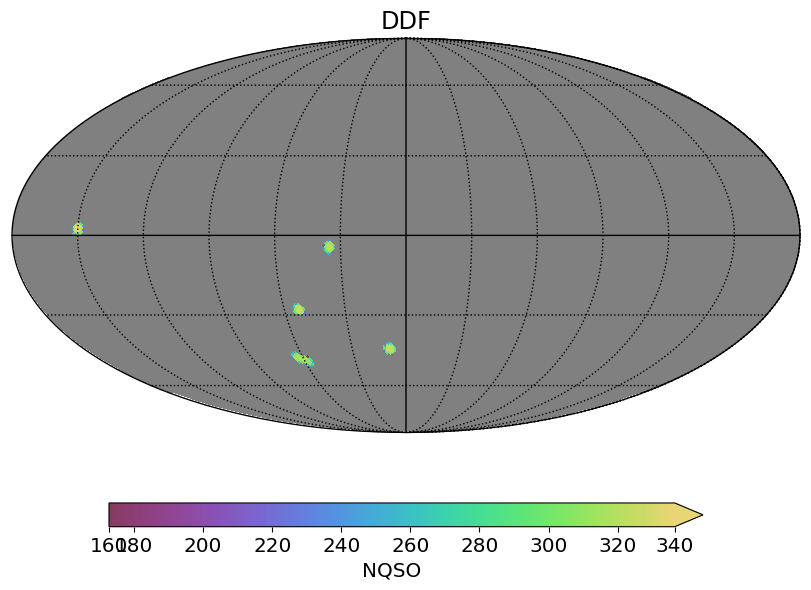

In [15]:
def plot_mollweide_projection(bundles, filter_band, title, xlabel, color_min=None, color_max=None, figformat='png'):
    """
    Plot a Mollweide projection for the specified filter band.

    Parameters:
    bundles (dict): Metric bundles for each filter.
    filter_band (str): Filter band to plot ('u', 'g', 'r', 'i', 'z', 'y').
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    color_min (float, optional): Minimum value for the color bar.
    color_max (float, optional): Maximum value for the color bar.
    out_dir (str, optional): Directory to save the output plot.
    opsim (str, optional): Name of the opsim run.
    figformat (str, optional): Format of the output plot, default is 'png'.

    Returns:
    int: Always returns 0.
    """
    bundle = bundles[filter_band]

    plot_dict = {
        'figsize': (8, 7),
        'labelsize': 'x-large',
        'fontsize': 'x-large',
        'xlabel': xlabel,
        'extend': 'max'
    }
    if color_min is not None:
        plot_dict['color_min'] = color_min
    if color_max is not None:
        plot_dict['color_max'] = color_max

    ph = maf.PlotHandler(savefig=False, fig_format=figformat, thumbnail=False, dpi=270)
    ph.set_metric_bundles([bundle])
    ph.plot(plot_func=maf.plots.HealpixSkyMap(), plot_dicts=plot_dict)
    
    plt.title(title, fontsize='xx-large', fontweight='normal')
    
    plt.show()

plot_mollweide_projection(NQSO_bundles_DDF, 'u', 'DDF', 'NQSO', color_min=None, color_max=None, figformat='png')